In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.autograd import Variable
from sklearn.preprocessing import normalize
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
from pathlib import Path
import FinanceDataReader as fdr
import seaborn as sns

In [2]:
df_kospi = fdr.StockListing('KOSPI')

def get_ticker(company_name):
    return str(df_kospi.loc[df_kospi['Name'] == company_name]['Symbol'].values[0])

In [3]:
samsung = fdr.DataReader(get_ticker('호텔신라'))
samsung

,Open,High,Low,Close,Volume,Change
Date,,,,,,
1997-11-04,4965,5470,4965,5470,39410,NaN
1997-11-05,5517,5695,5274,5470,58380,0.000000
1997-11-06,5424,5508,5143,5423,19880,-0.008592
1997-11-07,5330,5377,4993,4993,21530,-0.079292
1997-11-08,4694,4834,4601,4675,37620,-0.063689
...,...,...,...,...,...,...
2021-11-30,72200,72800,70200,70600,931600,-0.022161
2021-12-01,70600,72300,70000,72000,447766,0.019830
2021-12-02,71000,73900,70800,73500,321662,0.020833


Text(0, 0.5, 'price')

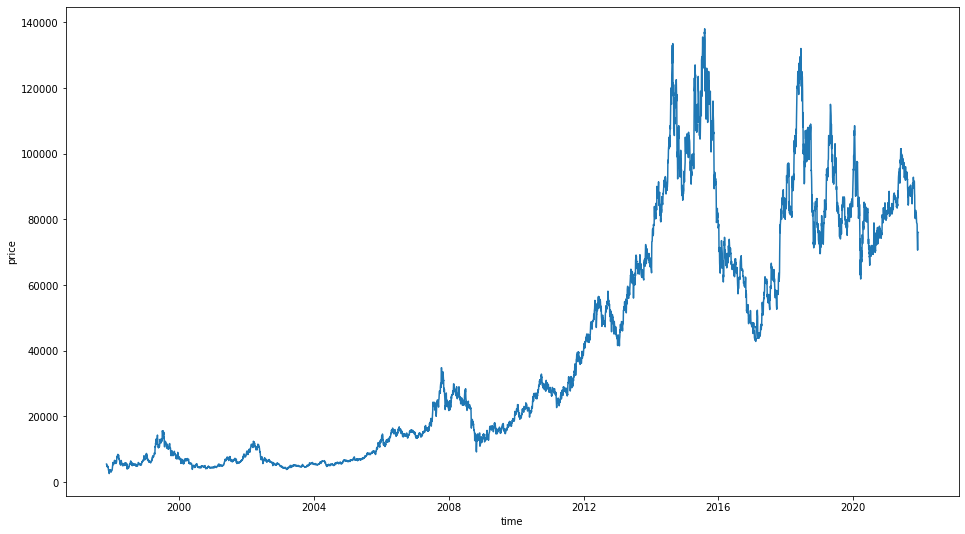

In [4]:
plt.figure(figsize=(16, 9))
sns.lineplot(y=samsung['Close'], x=samsung.index)
plt.xlabel('time')
plt.ylabel('price')

In [5]:
from sklearn.preprocessing import MinMaxScaler

price = samsung[['Close']]
scaler = MinMaxScaler(feature_range=(-1, 1))
price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))
price

/home/minhyuk/venv/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,Close
Date,
1997-11-04,-0.957058
1997-11-05,-0.957058
1997-11-06,-0.957752
1997-11-07,-0.964102
1997-11-08,-0.968798
...,...
2021-11-30,0.004711
2021-12-01,0.025384
2021-12-02,0.047535


In [6]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

lookback = 20 # choose sequence length
x_train, y_train, x_test, y_test = split_data(price, lookback)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (4784, 19, 1)
y_train.shape =  (4784, 1)
x_test.shape =  (1196, 19, 1)
y_test.shape =  (1196, 1)


In [7]:
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)

In [8]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100

In [9]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [10]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [11]:
import time
hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []
for t in range(num_epochs):
    y_train_pred = model(x_train)
    loss = criterion(y_train_pred, y_train_lstm)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.6721474528312683
Epoch  1 MSE:  0.45055508613586426
Epoch  2 MSE:  0.24720609188079834
Epoch  3 MSE:  0.1681186854839325
Epoch  4 MSE:  0.23411644995212555
Epoch  5 MSE:  0.15578556060791016
Epoch  6 MSE:  0.13335882127285004
Epoch  7 MSE:  0.14197295904159546
Epoch  8 MSE:  0.14354951679706573
Epoch  9 MSE:  0.1272989809513092
Epoch  10 MSE:  0.09608826786279678
Epoch  11 MSE:  0.06517770886421204
Epoch  12 MSE:  0.06148206442594528
Epoch  13 MSE:  0.06996849179267883
Epoch  14 MSE:  0.046813301742076874
Epoch  15 MSE:  0.020865166559815407
Epoch  16 MSE:  0.02131134644150734
Epoch  17 MSE:  0.03186526522040367
Epoch  18 MSE:  0.027408313006162643
Epoch  19 MSE:  0.016926590353250504
Epoch  20 MSE:  0.018330108374357224
Epoch  21 MSE:  0.02439344860613346
Epoch  22 MSE:  0.022869445383548737
Epoch  23 MSE:  0.015130517072975636
Epoch  24 MSE:  0.008756396360695362
Epoch  25 MSE:  0.0075887166894972324
Epoch  26 MSE:  0.00987304374575615
Epoch  27 MSE:  0.0120926592499

In [12]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_lstm.detach().numpy()))

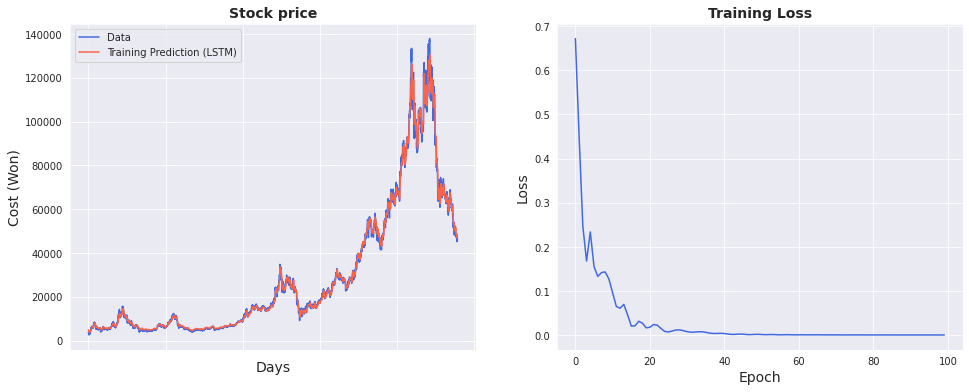

In [13]:
sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (LSTM)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (Won)", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

In [14]:
import math, time
from sklearn.metrics import mean_squared_error

# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train_lstm.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_lstm.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
lstm.append(trainScore)
lstm.append(testScore)
lstm.append(training_time)

Train Score: 1873.08 RMSE
Test Score: 3431.80 RMSE


Text(0, 0.5, 'Cost (Won)')

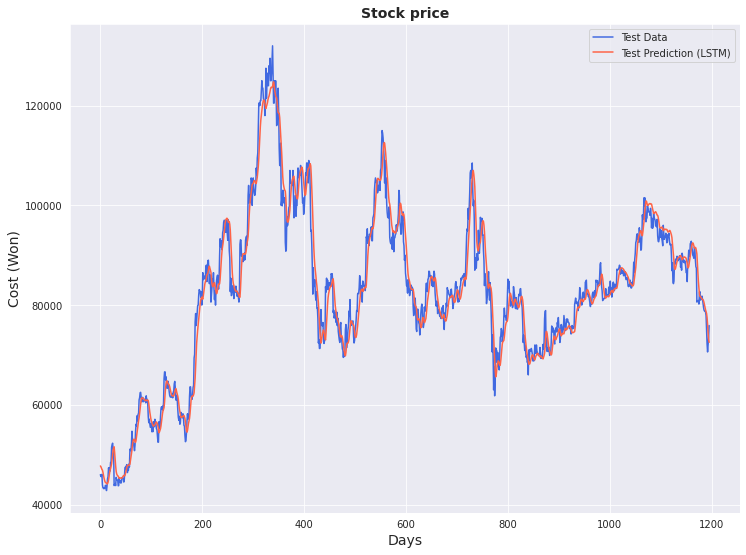

In [15]:
sns.set_style("darkgrid")    

plt.figure(figsize=(12, 9))
predict_test = pd.DataFrame(y_test_pred)
original_test = pd.DataFrame(y_test)
ax = sns.lineplot(x = original_test.index, y = original_test[0], label="Test Data", color='royalblue')
ax = sns.lineplot(x = predict_test.index, y = predict_test[0], label="Test Prediction (LSTM)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (Won)", size = 14)

In [16]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(price)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lookback:len(y_train_pred)+lookback, :] = y_train_pred

# shift test predictions for plotting
testPredictPlot = np.empty_like(price)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred)+lookback-1:len(price)-1, :] = y_test_pred

original = scaler.inverse_transform(price['Close'].values.reshape(-1,1))

predictions = np.append(trainPredictPlot, testPredictPlot, axis=1)
predictions = np.append(predictions, original, axis=1)
result = pd.DataFrame(predictions)

In [18]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[0],
                    mode='lines',
                    name='Train prediction')))
fig.add_trace(go.Scatter(x=result.index, y=result[1],
                    mode='lines',
                    name='Test prediction'))
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[2],
                    mode='lines',
                    name='Actual Value')))
fig.update_layout(
    xaxis=dict(
        showline=True,
        showgrid=True,
        showticklabels=False,
        linecolor='white',
        linewidth=2
    ),
    yaxis=dict(
        title_text='Close (Won)',
        titlefont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
        showline=True,
        showgrid=True,
        showticklabels=True,
        linecolor='white',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
    ),
    showlegend=True,
    template = 'plotly_dark'
)
annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Results (LSTM)',
                              font=dict(family='Rockwell',
                                        size=26,
                                        color='white'),
                              showarrow=False))
fig.update_layout(annotations=annotations)

fig.show()